SANTIAGO MONDELO LAGOMARSINO, JORGE SÁEZ SALTO , MIGUEL XUCLÁ HERRERO

# Práctica 3. Optimización de un modelo de ingeniería usando un algoritmo genético

<div style="text-align: center; font-size: 36px;">
    <strong>Optimización de una hélice</strong>
</div>
<p style="text-align: center;">Practica sesion 7:  Algoritmos genéticos</p>

A menudo, en ingeniería tenemos simulaciones de un modelo y hay que optimizar sus parámetros sin disponer de una fórmula explícita que relacione los parámetros con el comportamiento del modelo. Nos plantearemos un problema de ese tipo: tenemos una función que calcula las propiedades de una hélice en función de una serie de parámetros, pero no conocemos los cálculos que hace internamente. Disponemos de una caja negra que es un modelo de simulación (créditos: Siro Moreno y Carlos Dorado)

Aunque no es imprescindible conocer todos los detalles del modelo sí es recomendable familiarizarnos con los parámetros de configuración de la hélice que vamos a optimizar. 

En esta práctica vamos ha hacer un algoritmo genético haciendo uso de funciones y metodos vistos en clase: funciones de mutación, cruce, genereaciones de individuos y selección por torneo.

In [332]:
from modelo.helice import *
import numpy as np
import copy

In [334]:
help(calcular_helice)

Help on function calcular_helice in module modelo.helice:

calcular_helice(omega, vz, R, b, h=0, theta0=0.174, tors_param=['h', 14], chord_params=0.05)
    Calcula las propiedades de una hélice.

    Argumentos obligatorios:

        - omega: velocidad de giro de la hélice, en rad/s
        - vz: velocidad de avance, en m/s
        - R : radio de la hélice
        - b : número de palas

    Argumentos opcionales:

        - h : altitud de vuelo, en metros sobre el nivel del mar
        - theta0 : ángulo de paso colectivo
        - tors_param : parámetros de torsión de la hélice:
            formato: [ley, p]
                p: Parámetro: número o lista
                Ley:describe la forma de la ley de torsiones, y puede ser:
                    - 'c': distribución de torsión constante = p
                    - 'l': distribución de torsión lineal, con p[0] en la raíz y p[1] en la punta
                    - 'h': distribución de torsión hiperbólica, con torsión p en la punta
        - c

Lo primero que tendrás que hacer es definir una representación adecuada para los cromosomas que representan un diseño de la hélice en base a sus parámetros. Nuestra hélice depende de varios parámetros que queremos optimizar. Podemos decidir optimizar algunos mateniendo un valor controlado de otros. 

***Como sugerencia*** se proponen los siguientes parámetros de optimización: 

- omega (velocidad de rotación) (Entre 0 y 200 radianes/segundo)
- R (radio de la hélice) (Entre 0.1 y 2 metros)
- b (número de palas) (Entre 2 y 5 palas) 
- theta0 (ángulo de paso colectivo) (Entre -0.26 y 0.26 radianes)(*se corresponde a -15 y 15 grados*)
- p (parámetro de torsión) (Entre -5 y 20 grados)
- cuerda (anchura de la pala) (Entre 0.01 y 0.2 metros)

y fijar los parámetros:
- vz (velocidad de vuelo)
- h (altura de vuelo)

Ten en cuenta que necesitarás funciones de decodificación hay que transformar la representación binaria en variables con sentido físico. Por ejemplo, si el entero de la variable Omega está entre 0 y 1023 (10bits), pero la variable Omega real estará entre 0 y 200 radianes por segundo, el valor se calcula como:
    omega = genes[0] * 200 / 1023
    
del mismo modo, para R:
    R =  0.1 + genes[1] * 1.9 / 1023 #Obtendremos un radio entre 0.1 y 2 metros
    
El número de palas debe ser un entero:
    b = genes[2] + 2 #(entre 2 y 5 palas)
    
    
Para la función de fitness usaremos la función que calcula el desempeño del rotor según sus parámetros:

    T, P, efic, mach_punta = calcular_rotor(omega, vz, R, b, h...) #Introduce las variables que uses de parámetro.
                                                                # Consulta la ayuda para asegurarte de que usas el 
                                                                # formato correcto!
Recuerda que T es la tracción de la hélice, P es la Potencia consumida por la hélice, efic representa la eficiencia propulsiva de la hélice y mach_punta representa el mach en la punta de las palas. El número de mach en las puntas de la hélice se refiere a la velocidad relativa de las puntas de la hélice con respecto a la velocidad del sonido en el aire circundante.

Antes de seguir vamos a observar en las gráficas cómo cambian las características de la hélice (tracción, potencia, eficiencia y mach de las puntas) para cada valor de velocidad de vuelto (avance en m/s). Fijamos unos ciertos parámetros para ver el desempeño de la hélice.    

In [338]:
%matplotlib inline
import matplotlib.pyplot as plt
import random

In [340]:
vel = np.linspace(0, 30, 100)
# La función linspace() devuelve 100 valores espaciados uniformemente dentro del intervalo especificado [0, ] 
# zeros_like return an array of zeros with the same shape and type as a given array.
efic = np.zeros_like(vel)
T = np.zeros_like(vel)
P = np.zeros_like(vel)
mach = np.zeros_like(vel)
for i in range(len(vel)):
    T[i], P[i], efic[i], mach[i] = calcular_helice(130, vel[i], 0.5, 3)

Text(0.5, 1.0, 'Eficiencia de la hélice')

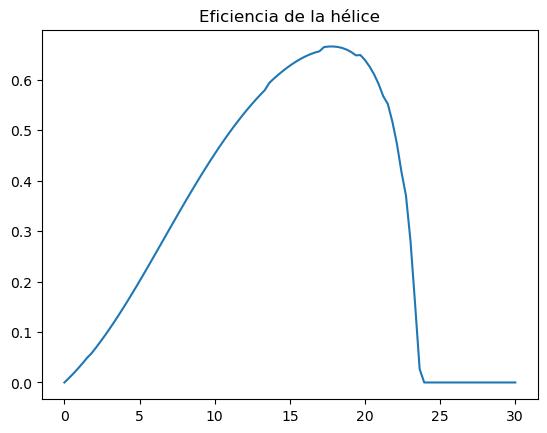

In [342]:
plt.plot(vel, efic)
plt.title('Eficiencia de la hélice')

Text(0.5, 1.0, 'Tracción de la hélice')

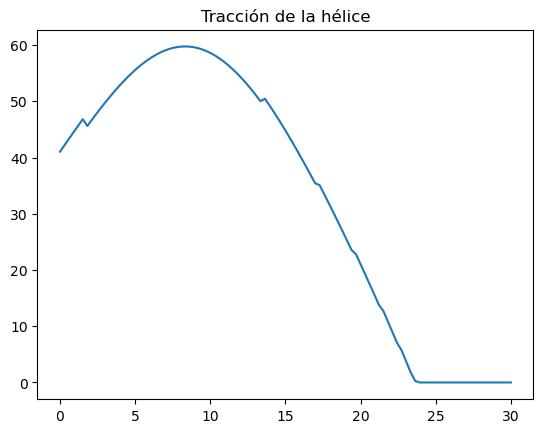

In [343]:
plt.plot(vel, T)
plt.title('Tracción de la hélice')

Text(0.5, 1.0, 'Potencia consumida')

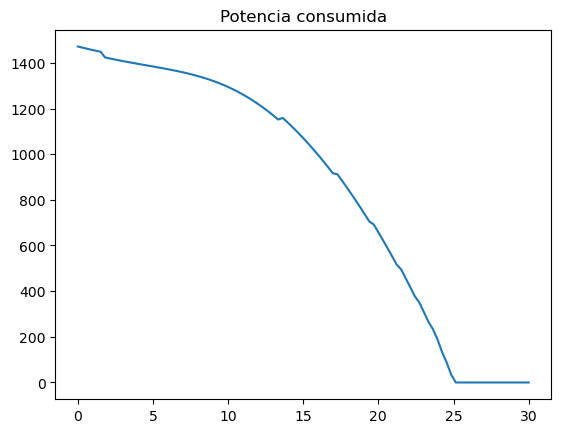

In [345]:
plt.plot(vel, P)
plt.title('Potencia consumida')

Text(0.5, 1.0, 'Mach en la punta de las palas')

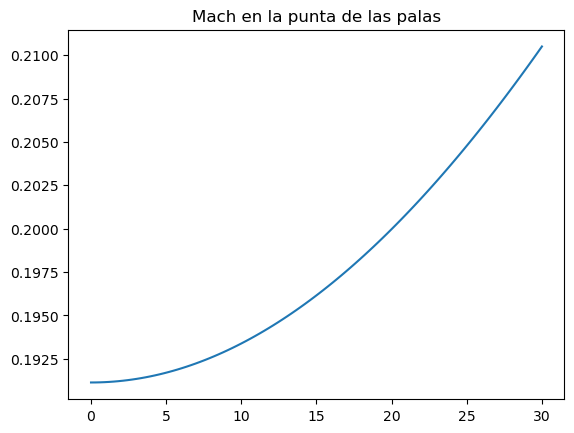

In [347]:
plt.plot(vel, mach)
plt.title('Mach en la punta de las palas')

Si quieres puedes observar también el impacto del resto de parámetros. 

Para la ejecución del algoritmo tendrás que definir una **función de fitness** adecuada según lo que decidas optimizar.

Por ejemplo, si buscáramos que tuviera la tracción máxima sin preocuparnos de nada más, el valor de fitnes sería simplemente igual al de T:

    fitness = T

Si queremos imponer restricciones, por ejemplo, que la potencia sea menor a 1000 watios, se pueden añadir sentencias del tipo:

    if P > 1000:
        fitness -= 1000
        
Si queremos optimizar varias salidas podemos hacerlo de manera ponderada:

    fitness = parámetro_importante * 10 + parámetro_poco_importante * 0.5
    
También se pueden combinar diferentes funciones no lineales:

    fitness = parámetro_1 * parámetro_2 - parámetro_3 **2 * log(parámetro_4)

Puedes elegir con qué objetivo quieres optimizar la hélice pero te hacemos algunas sugerencias de posibles objetivos de optimización:

    - Maximizar la tracción (manteniendo una tracción mínima de 30 Newtons) con el mínimo radio posible.
    - Mínima potencia consumida posible, máxima eficiencia propulsiva, y mínimo radio posible (sin ser este criterio muy importante), manteniendo una tracción mínima de 40 Newtons y un mach en la punta de las palas de como mucho 0.7
    - Máximizar la eficiencia cuando vuela a 70 m/s, y maximizar la tracción por encima de 50 Newtons para el despegue (vz = 0)    

### Se pide utilizar un algoritmo genético para encontrar la mejor configuración de parámetros para el modelo de hélice dado y comentar los resultados obtenidos. 

Documentar convenientemente el código y justificar las decisiones para la configuración del algoritmo genético. 

Utilizaremos una lista y una funcion que nos permita crear una gráfica para los mejores individuos de cada "step" generaciones

In [352]:
better_fitness = []

Función de Gráfico

In [27]:
def graficar_generacion(b_fitness, step):
    """
    Genera un gráfico de premios y castigos con anotaciones y etiquetas personalizadas.

    Args:
        b_fitness (list): Lista de cantidades de premios por simulación.
    """
    fitness = [b_fitness[i]/100000 for i in range(1, len(b_fitness) + 1, step)]
    
    x = [i for i in range(1, len(b_fitness) + 1, step)]
    
    # Graficar premios y castigos
    plt.plot(x,fitness, marker='o', label="Premios")
    
    # Anotaciones en los puntos
    for ab in zip(x, fitness):
        plt.annotate('(%d, %d)' % ab, xy=ab)

    # Configuración de etiquetas y título
    font = {'family': 'serif', 'color': 'black', 'size': 9}
    plt.ylabel("Mejor individuo", fontdict=font)
    plt.xlabel(f"Generación", fontdict=font)
    plt.title(f"Mejor individuo de cada generación "
               f"", fontdict=font)
    
    # Configuración de rejilla y mostrar gráfico
    plt.grid()
    plt.legend()
    plt.show()

Declaramos la clase ProblemaGenetico

In [404]:
class ProblemaGenetico(object):
        def __init__(self, genes,fun_dec,fun_muta , fun_cruza, fun_fitness,longitud_individuos):
            self.genes = genes
            self.fun_dec = fun_dec
            self.fun_cruza = fun_cruza
            self.fun_muta = fun_muta
            self.fun_fitness = fun_fitness
            self.longitud_individuos = longitud_individuos
            """Constructor de la clase"""
                
        def decodifica(self, genotipo):
            """Devuelve el fenotipo a partir del genotipo"""
            fenotipo = self.fun_dec(genotipo)
            return fenotipo
        def muta(self, cromosoma,prob):
            """Devuelve el cromosoma mutado"""   
            mutante = self.fun_muta(cromosoma,prob)
            return mutante
        def cruza(self, cromosoma1, cromosoma2):         
            """Devuelve el cruce de un par de cromosomas"""
            cruce = self.fun_cruza(cromosoma1,cromosoma2)
            return cruce 
        def fitness(self, cromosoma):    
            """Función de valoración"""
            valoracion = self.fun_fitness(cromosoma)
            return valoracion

In [432]:
#Definir la función nueva_generacion
def nueva_generacion(problema_genetico, k, opt, poblacion, n_padres, n_directos, prob_mutar):
    padres2 = seleccion_por_torneo(problema_genetico, poblacion, n_directos, k,opt) 
    padres1 = seleccion_por_torneo(problema_genetico, poblacion, n_padres, k, opt)
    cruces =  cruza_padres(problema_genetico,padres1)
    generacion = padres2+cruces
    resultado_mutaciones = muta_individuos(problema_genetico, generacion, prob_mutar)
    seleccionado = opt( resultado_mutaciones, key=problema_genetico.fitness)
    better_fitness.append(problema_genetico.fitness(seleccionado))
    return resultado_mutaciones

Usamos la función de algortimo genético que se encargara de crear las generaciones

In [434]:
def algoritmo_genetico(problema_genetico,k,opt,ngen,size,prop_cruces,prob_mutar):
    poblacion= poblacion_inicial(problema_genetico,size)
    n_padres=round(size*prop_cruces)
    n_padres= int (n_padres if n_padres%2==0 else n_padres-1)
    n_directos = size-n_padres
    i = 0
    for _ in range(ngen):
        i += 1
        poblacion= nueva_generacion(problema_genetico,k,opt,poblacion,n_padres, n_directos,prob_mutar)

    print("Poblacion final: ")
    for p in poblacion:
        print(fun_fitness(p))
    mejor_cr = opt(poblacion, key=problema_genetico.fitness)
    mejor = problema_genetico.decodifica(mejor_cr)
    return (mejor, problema_genetico.fitness(mejor_cr)) 

In [362]:
# Será necesaria la siguiente función que interpreta una lista de 0's y 1's como un número natural:  
def binario_a_decimal(x):
    x=x[::-1]
    #result = sum(b * (2**i) for (i, b) in enumerate(x))
    result = np.sum(np.fromiter((b * (2**i) for (i, b) in enumerate(x)), dtype=float))
    return result

In [430]:
def poblacion_inicial(problema_genetico, size):
    """
    Genera una población inicial de individuos representados como listas de bits, 
    cada uno siguiendo una estructura específica de sublistas.
    
    :param problema_genetico: Un objeto que contiene información sobre los genes y la longitud deseada.
    :param size: El tamaño de la población (número de individuos).
    :return: Una lista de individuos, donde cada individuo es una lista de listas de bits.
    """
    # Definir la estructura específica de cada individuo: [[10 bits], [10 bits], [2 bits], [10 bits], [10 bits], [10 bits]]
    estructura = [10, 10, 2, 10, 10, 10]
    
    poblacion = []  # Lista para almacenar la población
    
    for _ in range(size):
        individuo = []  # Cada individuo será una lista de listas
        for longitud in estructura:
            # Generar una sublista de bits de la longitud especificada en 'estructura'
            sublista = [random.choice(problema_genetico.genes) for _ in range(longitud)]
            individuo.append(sublista)
        '''Obligamos a que todos los individuos tengan un fitness mayor que 0 para garantizar un comienzo decente
        Hemos comprobado que esto no aumenta mucho el tiempo de ejecución así que lo hemos dejado. De todos modos, 
        sin este cambio los individuos siguen evolucionando bastante bien.'''
        while fun_fitness(individuo) < 0:
            individuo = []
            for longitud in estructura:
                # Generar una sublista de bits de la longitud especificada en 'estructura'
                sublista = [random.choice(problema_genetico.genes) for _ in range(longitud)]
                individuo.append(sublista)
        poblacion.append(individuo)  # Añadir el individuo generado a la población
    
    return poblacion

In [366]:
def cruza_padres(problema_genetico,padres):
    l = []
    for i in range(len(padres)//2):# asumimos que la población de la que partimos tiene tamaño par
        desc = problema_genetico.fun_cruza(padres[2*i],padres[2*i+1]) # El cruce se realiza con la función de cruce  
                                                                     # proporcionada por el propio problema genético
        l.append(desc[0]) # La población resultante se obtiene de cruzar el padre[0] con padre[1], padre[2] con padre[3]...
        l.append(desc[1]) # y añadir cada par de descendientes a la nueva población
    return l

In [368]:
def muta_individuos(problema_genetico, poblacion, prob):
    mutados = []
    for x in poblacion:
        mutados.append(problema_genetico.fun_muta(x,prob))
    return mutados

In [370]:
def seleccion_por_torneo(problema_genetico, poblacion, n, k, opt):
    """Selección por torneo de n individuos de una población. Siendo k el nº de participantes
        y opt la función max o min."""
    seleccionados = []
    opt = max
    for i in range(n):
        participantes = random.sample(poblacion,k)
        seleccionado = opt(participantes, key=problema_genetico.fitness)
        opt(poblacion, key=problema_genetico.fitness)
        seleccionados.append(seleccionado)
        # poblacion.remove(seleccionado)
    return seleccionados 

In [372]:
def print_cromosoma(numeros):
    print("ω: " + str(numeros[0]))
    print("R: " + str(numeros[1]))
    print("b: " + str(numeros[2]))
    print("θ: " + str(numeros[3]))
    print("Torsion: " + str(numeros[4]))
    print("Cuerda: " + str(numeros[5]))
    print("---------------------------------")


Creamos la función decodificador que nos permitira traducir los cromsomas (listas de bits o genes) en los valores especificados por el enunciado

In [374]:
def funcion_decodificador(genotipo):
    p_values = ['c','l','h']
    numeros = [binario_a_decimal(elemento) for elemento in genotipo]
    omega = binario_a_decimal(genotipo[0])*200/1023
    r = 0.1 + binario_a_decimal(genotipo[1]) * 1.9/1023
    b = binario_a_decimal(genotipo[2]) + 2
    theta = -0.26 + binario_a_decimal(genotipo[3]) * 0.52/1023
    ley = p_values[int(binario_a_decimal(genotipo[4][0:2])%3)] 
    p1 = 0
    p2 = 0
    if ley == 'l':
        p1 = float(-5 + binario_a_decimal(genotipo[4][2:6]) * 25/127)
        p2 = float(-5 + binario_a_decimal(genotipo[4][6:10]) * 25/127)
    else:
        p1 = float(-5 + binario_a_decimal(genotipo[4][2:10]) * 25/255)

    p = [ley, p1 if ley != 'l' else [p1, p2]]
    cuerda = float(0.01 + binario_a_decimal(genotipo[5])*0.19/1023)

    numeros = [omega, r, b, theta, p, cuerda]
    return numeros
     

In [376]:
def fun_cruzar(cromosoma1, cromosoma2):
    """Cruza los cromosomas por la mitad (podemos cambiar la función de cruce eligiendo otro punto de cruce al azar)"""
    l1 = len(cromosoma1)
    l2 = len(cromosoma2)
    cruce1 = cromosoma1[0:l1//2]+cromosoma2[l1//2:l2]
    cruce2 = cromosoma2[0:l2//2]+cromosoma1[l2//2:l1]
    return [cruce1,cruce2]


def muta_individuos(problema_genetico, poblacion, prob):
    mutados = []
    for x in poblacion:
        """Hace falta hacer un deepcopy porque si no las listas terminan compartiendo memoria, de este modo lo evitamos. 
        Esto lo hemos notado al hacer varias pruebas, ya que terminaban siendo todos los individuos iguales y eventualmente 
        descendían hasta un fitness de -300 aproximadamente. Esto, por mucho que suene a broma es comparable a la naturaleza, 
        ya que es como si todos los individuos al ser el mismo fueran algo parecido a "hermanos", provocando que cualquier mutación se cargue todos"""
        copia = copy.deepcopy(x)
        mutados.append(problema_genetico.fun_muta(copia,prob))
    return mutados

Definimos la función de fitness dada por la funcion de caja negra del simulador helice.py ademas de usar las ponderaciones, en este caso queremos mantener una tracción minima de 30 newtons con el menor radio posible para ello hemos utilizado la expresión :
### n = (T - 30) * 10 - R * 5

In [378]:
def fun_fitness(cromosoma):
    omega, R, b, theta0, p, cuerda = funcion_decodificador(cromosoma)

    #fijar estos dos
    vz = 50
    h = 100
    
    T, P, efic, mach_punta = calcular_helice(omega, vz, R, b, h, theta0, p, float(cuerda))

    #función(es) de fitness real
    n = (T - 30) * 10 - R * 5 #Maximizar la tracción (manteniendo una tracción mínima de 30 Newtons) con el mínimo radio posible.
    '''n = - P * 10 + efic * 10 - R * 4 + (T - 40) * 10 - (mach_punta - 0.7 * 10 #Mínima potencia consumida posible, máxima eficiencia propulsiva, y mínimo radio posible (sin ser este criterio muy importante), manteniendo una tracción mínima de 40 Newtons y un mach en la punta de las palas de como mucho 0.7
    
    vz = 70
    T70, P70, efic70, mach_punta70 = calcular_helice(omega, vz, R, b, h, theta0, p, cuerda)
    vz = 0
    T0, P0, efic0, mach_punta0 = calcular_helice(omega, vz, R, b, h, theta0, p, cuerda)
    n = efic70 + (T0 - 50) #Máximizar la eficiencia cuando vuela a 70 m/s, y maximizar la tracción por encima de 50 Newtons para el despegue (vz = 0)'''
    return n

In [410]:
better_fitness = []

In [412]:
funcion1 = ProblemaGenetico([0,1],funcion_decodificador, fun_mutar, fun_cruzar, fun_fitness, 52)

In [414]:
mejor_individuo = algoritmo_genetico(funcion1,6,max,40,20,0.7,0.2)

1
12428.37894916697
2
5451.701611601996
3
38128.134955510664
4
125400.81166799307
5
5075.414759037177
6
68412.92073312403
7
4881.0710707753515
8
152002.04531582896
9
46737.42345554865
10
32876.880131808124
11
11874.800565501273
12
7600.755164101327
13
88310.28597025375
14
6410.447552213399
15
5676.162206079526
16
37019.60951157477
17
4466.384316640343
18
24850.389153596072
19
2527.7761914183593
20
4981.835956741445
Padres 1 fitness: 

125400.81166799307
152002.04531582896
68412.92073312403
38128.134955510664
88310.28597025375
125400.81166799307
Padres 2 fitness: 

46737.42345554865
152002.04531582896
152002.04531582896
125400.81166799307
125400.81166799307
88310.28597025375
152002.04531582896
88310.28597025375
68412.92073312403
152002.04531582896
125400.81166799307
152002.04531582896
24850.389153596072
68412.92073312403
Padres 1 fitness: 

428581.26965347223
179383.58731934507
432396.2657728206
428581.26965347223
432396.2657728206
169850.99992639764
Padres 2 fitness: 

428581.269653472

In [415]:
better_fitness

[432396.2657728206,
 432396.2657728206,
 488663.1383585356,
 534742.8315368294,
 534742.8315368294,
 535490.3475869731,
 535490.3475869731,
 535490.3475869731,
 536039.7682499533,
 539877.2869218478,
 540853.3843063148,
 544718.009905662,
 546557.0787223817,
 546557.0787223817,
 549555.204652128,
 589200.7812962369,
 590313.6849690325,
 593741.9706208273,
 593741.9706208273,
 593741.9706208273,
 593741.9706208273,
 593741.9706208273,
 593741.9706208273,
 593741.9706208273,
 593899.5015800324,
 593899.5015800324,
 593899.5015800324,
 647910.4348037436,
 648852.9731641412,
 648852.9731641412,
 648852.9731641412,
 648852.9731641412,
 648852.9731641412,
 650261.8689373356,
 650261.8689373356,
 652253.8172522481,
 653596.1939247908,
 653596.1939247908,
 653850.0847645319,
 653850.0847645319]

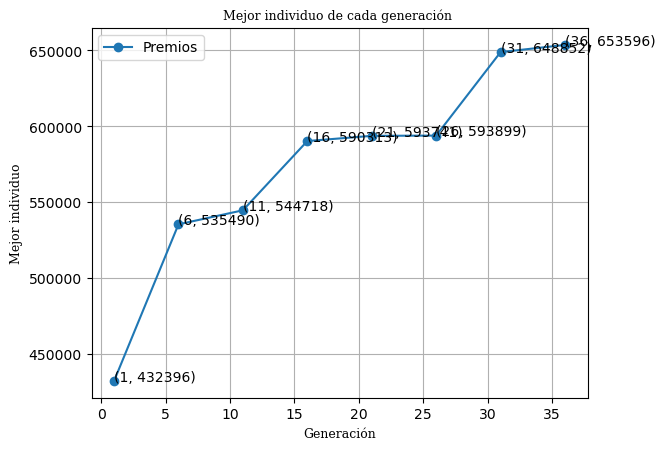

'Gracias a esta gráfica y a las múltiples pruebas q hemos hecho podemos ver que los individuos evolucionan al principio muy rápido y \nluego la evolución se ralentiza. Antes de hacer la modificación en la función de mutación los individuos empezaban mejorando, luego se \nigualaban y eventualmente empeoraban en picado'

In [428]:
graficar_generacion(better_fitness, 5)
'''Gracias a esta gráfica y a las múltiples pruebas q hemos hecho podemos ver que los individuos evolucionan al principio muy rápido y 
luego la evolución se ralentiza. Antes de hacer la modificación en la función de mutación los individuos empezaban mejorando, luego se 
igualaban y eventualmente empeoraban en picado'''

In [426]:
print("Atributos del mejor individuo: \n")
print_cromosoma(mejor_individuo[0])
print("Fitness: {}".format(mejor_individuo[1]))

Atributos del mejor individuo: 

ω: 200.0
R: 2.0
b: 5.0
θ: 0.2254349951124145
Torsion: ['c', 19.215686274509803]
Cuerda: 0.19981427174975563
---------------------------------
Fitness: 653850.0847645319


In [455]:
better_fitness = []
mejor_individuo = algoritmo_genetico(funcion1,6,max,100,20,0.7,0.2)

Poblacion final: 
643134.2268673237
643134.2268673237
641086.1448910004
643134.2268673237
641086.1448910004
643134.2268673237
643134.2268673237
643134.2268673237
643134.2268673237
643134.2268673237
643134.2268673237
643134.2268673237
643134.2268673237
643134.2268673237
643134.2268673237
643134.2268673237
643134.2268673237
643134.2268673237
643134.2268673237
643134.2268673237


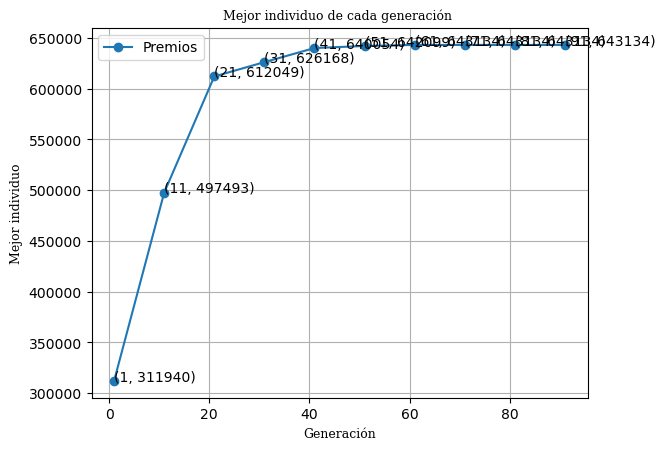

Atributos del mejor individuo: 

ω: 200.0
R: 2.0
b: 5.0
θ: 0.1949364613880743
Torsion: ['c', 20.0]
Cuerda: 0.2
---------------------------------
Fitness: 643134.2268673237


'De todas formas, aún mejorando el algoritmo y arreglando el problema de las mutaciones hay picos descendentes, \nesto se debe a ciertas mutaciones malas que no podemos controlar y es normal que sucedan en alguna generación de vez en cuando'

In [456]:
graficar_generacion(better_fitness, 10)
print("Atributos del mejor individuo: \n")
print_cromosoma(mejor_individuo[0])
print("Fitness: {}".format(mejor_individuo[1]))
'''De todas formas, aún mejorando el algoritmo y arreglando el problema de las mutaciones hay picos descendentes, 
esto se debe a ciertas mutaciones malas que no podemos controlar y es normal que sucedan en alguna generación de vez en cuando'''

In [ ]:
better_fitness = []
mejor_individuo = algoritmo_genetico(funcion1,6,max,100,20,0.7,0.2)

In [ ]:
graficar_generacion(better_fitness, 5)